In [17]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [18]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [19]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [20]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [21]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [22]:
# View all of the classes that automap found
for c in Base.classes:
    print(c)

<class 'sqlalchemy.ext.automap.measurement'>
<class 'sqlalchemy.ext.automap.station'>


In [23]:
# Save references to each table
Measurements = Base.classes.measurement
Stations = Base.classes.station

In [24]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [25]:
# Find the most recent date in the data set.
last_measurement = session.query(Measurements).order_by(Measurements.date.desc()).first()
print(last_measurement.date)

2017-08-23


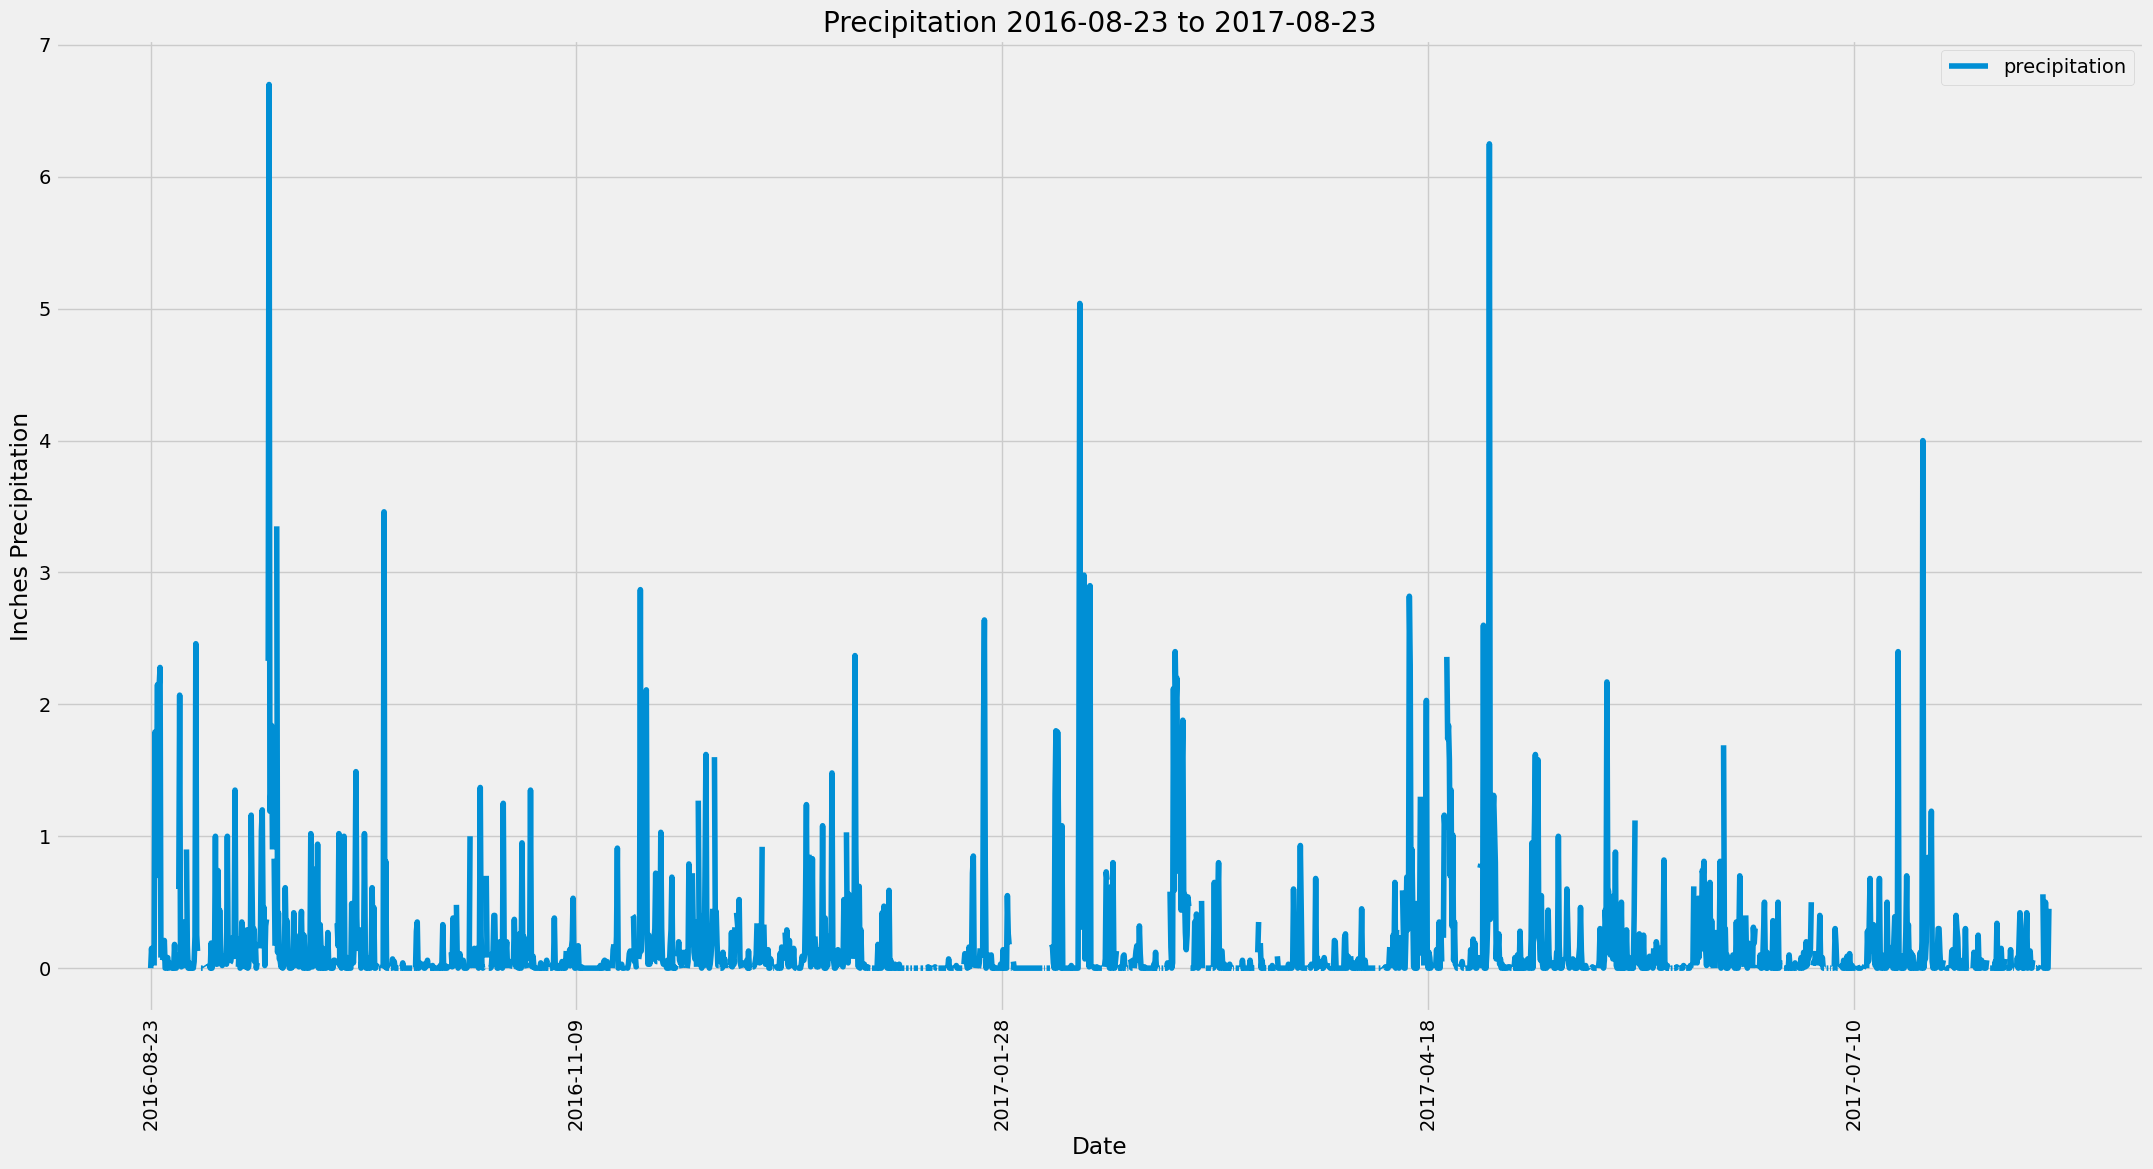

In [26]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
last_date_str = last_measurement.date
year,month,day = str.split(last_date_str,'-')
last_date = dt.date(int(year),int(month),int(day)) 

# Calculate the date one year from the last date in data set.
first_date = last_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precip_by_date = (session.query(
                    Measurements.date, 
                    #func.sum(Measurements.prcp)
                    Measurements.prcp
                    )
                .filter(Measurements.date >= first_date)
                .order_by(Measurements.date)
                .all())

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(precip_by_date, columns=['date', 'precipitation'])

# Sort the dataframe by date
prcp_df = prcp_df.sort_values('date', ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot.line('date', 'precipitation', figsize=(24,12))
plt.title(f'Precipitation {first_date} to {last_date}')
plt.ylabel("Inches Precipitation")
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.show()


In [27]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [28]:
# Design a query to calculate the total number of stations in the dataset
session.query(Stations.name).group_by(Stations.name).count()

9

In [29]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_measurements = (session.query(Measurements.station, func.count(Measurements.id))
                        .group_by(Measurements.station)
                        .order_by(func.count(Measurements.id).desc()).all())
station_measurements

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [30]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
busiest_station = station_measurements[0].station
station_temp = (session.query(
                Measurements.station,
                func.min(Measurements.tobs),
                func.max(Measurements.tobs), 
                func.sum(Measurements.tobs) / func.count(Measurements.tobs),
                func.count(Measurements.tobs)
                )
                .group_by(Measurements.station)
                .filter(Measurements.station == busiest_station).all())
df = pd.DataFrame(station_temp, columns=["Station","Minimum Temperature", "Maximum Temperature", "Average Temperature", "Records"]).set_index("Station")
df

,Minimum Temperature,Maximum Temperature,Average Temperature,Records
Station,,,,
USC00519281,54.0,85.0,71.663781,2772


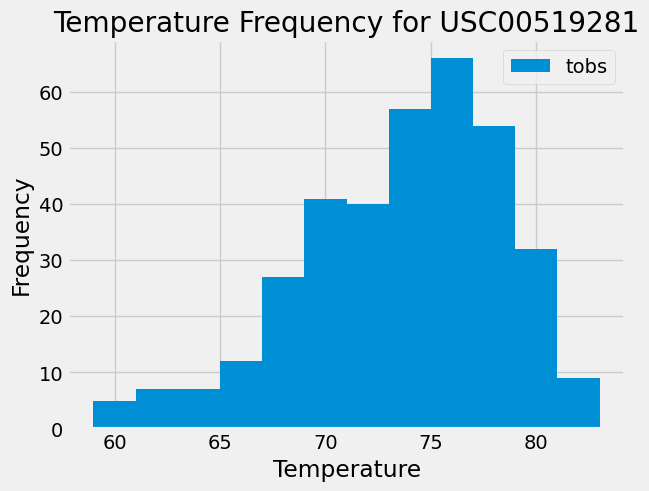

In [31]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_measurement = (session.query(Measurements)
                    .filter(Measurements.station == busiest_station)
                    .order_by(Measurements.date.desc()).first())

last_date_str = last_measurement.date
year,month,day = str.split(last_date_str,'-')
last_date = dt.date(int(year),int(month),int(day)) 

# Calculate the date one year from the last date in data set.
first_date = last_date - dt.timedelta(days=365)

# Perform a query to retrieve the temperature records for this station and date range
base_temp_records = (session.query(
                    Measurements.tobs
                    )
                .filter(Measurements.date >= first_date)
                .filter(Measurements.station == busiest_station)
                #.group_by(Measurements.date)
                .all())

# Save the query results as a Pandas DataFrame. Explicitly set the column names
temp_df = pd.DataFrame(base_temp_records, columns=['tobs'])
temp_df.plot.hist(bins=12)
plt.xlabel("Temperature")
plt.title(f"Temperature Frequency for {busiest_station}")
plt.show()


# Close Session

In [32]:
# Close Session
session.close()